# Parkinson's Disease Progression Prediction
### Project - SI 507: Intermediate Python Programing

### Exploratory Data Analysis
Authors
1. Nowrin Mohamed - nowrin@umich.edu

Kaggle link: https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction/overview

In [86]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from diskcache import Cache

In [87]:
# Create a cache object with a cache directory
cache = Cache('cache_dir')

# Define a function that loads the CSV file into a DataFrame and applies some transformations
def load_data(dir):
    # Check if the cached result exists
    if dir in cache:
        df = cache[dir]
    else:
        df = pd.read_csv(dir)
        cache['dir'] = df
    return df

In [88]:
# Read the data from the csv files into appropriate variables

clinical_data = load_data("data/train_clinical_data.csv")
clinical_data_copy = clinical_data.copy()
sup_clinical_data = load_data("data/supplemental_clinical_data.csv")
peptides_data = load_data("data/train_peptides.csv")
proteins_data = load_data("data/train_proteins.csv")

# Clinical data Analysis

The first part of the dataset is clinical data. Columns in clinical data are:

1. `visit_id`: ID of the visit 
2. `visit_month`: Month of the visit relative to the first visit by the patient 
3. `patient_id`: ID of the patient 
4. 5. 6. 7. `updrs_[1-4]`: The patient's score for part N of the Unified Parkinson's Disease Rating Scale 
8. `upd23b_clinical_state_on_medication`: Whether or not the patient was taking medication during the UPDRS assessment 

The Unified Parkinson's Disease Rating Scale (UPDRS) is a standardized assessment tool that is commonly used by healthcare providers and researchers to evaluate the severity of Parkinson's disease symptoms and to track changes in symptoms over time.

The UPDRS is a comprehensive assessment that covers a range of Parkinson's disease symptoms, including motor symptoms such as tremors, rigidity, and bradykinesia, as well as non-motor symptoms such as mood changes, sleep disturbances, and cognitive impairment. The assessment is divided into four parts:

`updrs_1`: Non-Motor Experiences of Daily Living (NEDL) - assesses the patient's ability to carry out daily activities and evaluates non-motor symptoms such as mood, sleep, and behavior. 

`updrs_2`: Motor Examination - assesses the patient's motor symptoms such as tremors, rigidity, bradykinesia, and postural instability.

`updrs_3`: Motor Section - assesses the patient's motor function, including activities such as finger tapping, hand movements, and walking.

`updrs_4`: Complications of Therapy - assesses the presence of side effects or complications of Parkinson's disease medications.

Each part of the UPDRS is scored on a scale of 0 to 4, with higher scores indicating more severe symptoms. The scores from each part are added together to obtain a total UPDRS score. A higher total score indicates more severe Parkinson's 

In [89]:
clinical_data.head(10)


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,6,NaN,NaN
1,55_3,55,3,10.0,7.0,19,NaN,NaN
2,55_6,55,6,8.0,10.0,58,NaN,NaN
3,55_9,55,9,8.0,9.0,17,0.0,On
4,55_12,55,12,10.0,10.0,2,0.0,On
5,55_18,55,18,7.0,13.0,7,0.0,On
6,55_24,55,24,16.0,9.0,16,0.0,On
7,55_30,55,30,14.0,13.0,21,0.0,On
8,55_36,55,36,17.0,18.0,9,0.0,On
9,55_42,55,42,12.0,20.0,4,0.0,On


In [90]:
clinical_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615 entries, 0 to 2614
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   visit_id                             2615 non-null   object 
 1   patient_id                           2615 non-null   int64  
 2   visit_month                          2615 non-null   int64  
 3   updrs_1                              2614 non-null   float64
 4   updrs_2                              2613 non-null   float64
 5   updrs_3                              2615 non-null   int64  
 6   updrs_4                              1577 non-null   float64
 7   upd23b_clinical_state_on_medication  1288 non-null   object 
dtypes: float64(3), int64(3), object(2)
memory usage: 163.6+ KB


As it can be seen from the above, there are `2615 rows` and `8 columns`.

In [91]:
clinical_data.describe()


,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
count,2615.000000,2615.000000,2614.000000,2613.000000,2615.000000,1577.000000
mean,32651.743786,31.190822,7.110559,6.742442,20.213384,1.861763
std,18535.758700,25.199053,5.525678,6.321699,20.760290,3.022112
min,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16574.000000,10.500000,3.000000,1.000000,4.000000,0.000000
50%,29417.000000,24.000000,6.000000,5.000000,9.000000,0.000000
75%,50611.000000,48.000000,10.000000,10.000000,21.000000,3.000000
max,65043.000000,108.000000,33.000000,40.000000,58.000000,20.000000


In [92]:
print(clinical_data.isna().sum())


visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   1
updrs_2                                   2
updrs_3                                   0
updrs_4                                1038
upd23b_clinical_state_on_medication    1327
dtype: int64


In [93]:
print("Found {:,d} unique patient_id values".format(
    clinical_data["patient_id"].nunique()))
print("Found {:,d} unique visit_month values".format(
    clinical_data["visit_month"].nunique()))


Found 248 unique patient_id values
Found 17 unique visit_month values


In [94]:
clinical_data["null_count"] = clinical_data.isnull().sum(axis=1)
counts_train_clinical_data = clinical_data.groupby(
    "null_count")["visit_id"].count().to_dict()
null_train_clinical_data = {
    "{} Null Value(s)".format(k): v for k,
    v in counts_train_clinical_data.items()}


As it can be seen from the above, there are null values present in clinical data. There are missing values in updrs columns because all of the assessments weren't necessarily done during each visit. There is only 1 missing value in updrs_1, 2 missing values in updrs_2, 25 missing values in updrs_3 and 1038 missing values in updrs_4 columns.

There are also 1327 missing values in upd23b_clinical_state_on_medication since patients' medication status were unknown for some of the visits. We are filling the missing values with the median of the data and for `upd23b_clinical_state_on_medication` we are filling it as `missing`.

In [95]:
def visualize_continuous_data_histogram(df, column, log_scale=False):
    """
    Visualize histogram of given continuous column in given dataframe

    Parameters
    ----------
    df: pandas.DataFrame
        Dataframe with given column

    column: str
        Name of the continuous column

    log_scale: bool
        Whether or not to do log transform on data
    """

    fig, ax = plt.subplots(figsize=(12, 3), dpi=100)
    x = df[column]
    if log_scale:
        x = np.log(x)
    sns.histplot(x, fill=True, log_scale=False, ax=ax)
    ax.tick_params(axis='x', labelsize=5.5)
    ax.tick_params(axis='y', labelsize=5.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    title = f'''
    {column}
    Mean: {df[column].mean():.2f}
    Median: {df[column].median():.2f}
    Std: {df[column].std():.2f}
    Min: {df[column].min():.2f}
    Max: {df[column].max():.2f}
    '''
    ax.set_title(title, size=10, pad=12.5)
    plt.show()


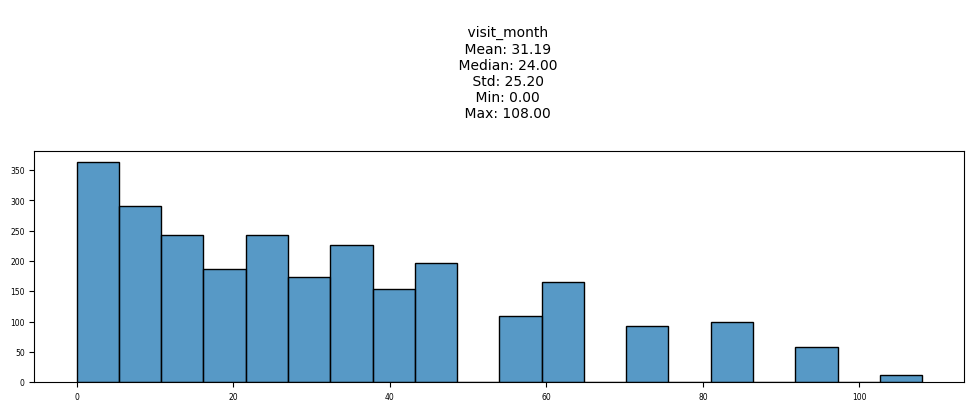

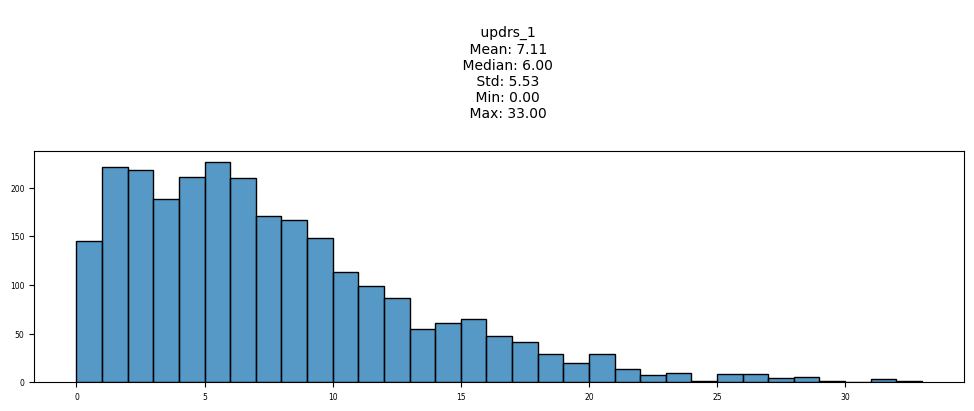

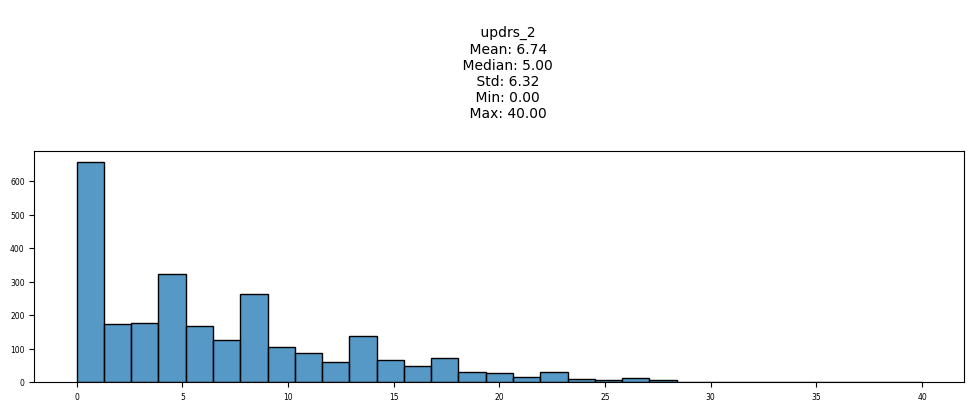

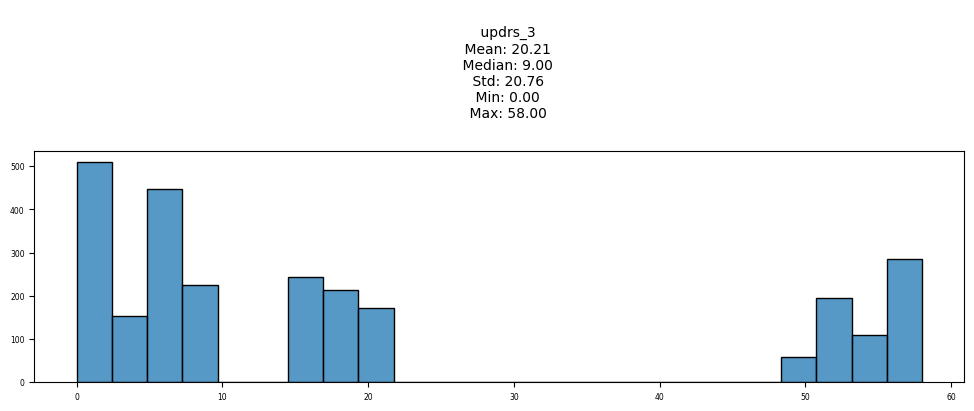

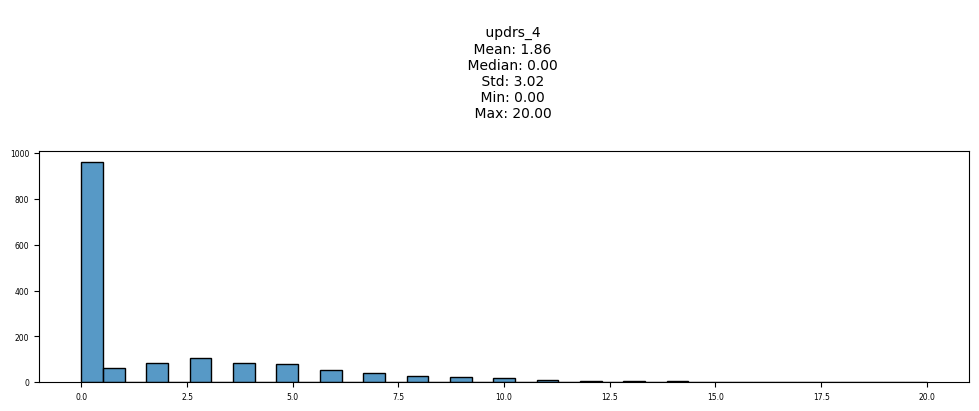

In [96]:
for column in ['visit_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']:
    visualize_continuous_data_histogram(df=clinical_data, column=column)


It can be seen from the histogram that the the counts of visit_month linearly decrease since least patients were coming for further visits as time goes. There are lots of 0 values in updrs_2, updrs_3 and updrs_4 but updrs_1 distribution is more balanced.

In [97]:
def visualize_categorical_column_counts(df, column):
    """
    Visualize counts of given categorical column in given dataframe

    Parameters
    ----------
    df: pandas.DataFrame
        Dataframe with given column

    column: str
        Name of the categorical column
    """

    fig, ax = plt.subplots(
        figsize=(
            10, df[column].value_counts().shape[0]), dpi=100)
    sns.barplot(
        y=df[column].value_counts().values,
        x=df[column].value_counts().index,
        color='tab:blue',
        ax=ax
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([
        f'{x} ({value_count:,})' for value_count, x in zip(
            df[column].value_counts().values,
            df[column].value_counts().index
        )
    ])
    ax.tick_params(axis='x', labelsize=15, pad=10)
    ax.tick_params(axis='y', labelsize=15, pad=10)
    ax.set_title(f'Counts {column}', size=20, pad=15)
    plt.show()


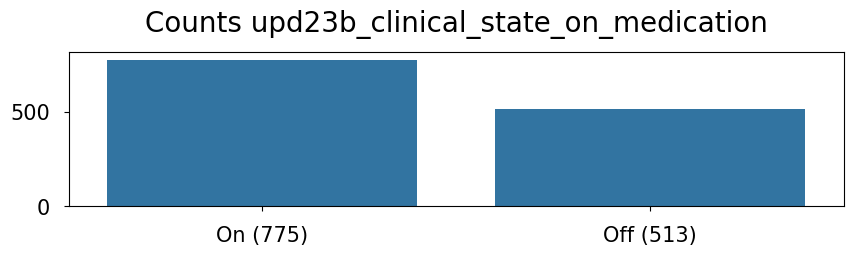

In [98]:
visualize_categorical_column_counts(
    df=clinical_data,
    column='upd23b_clinical_state_on_medication')


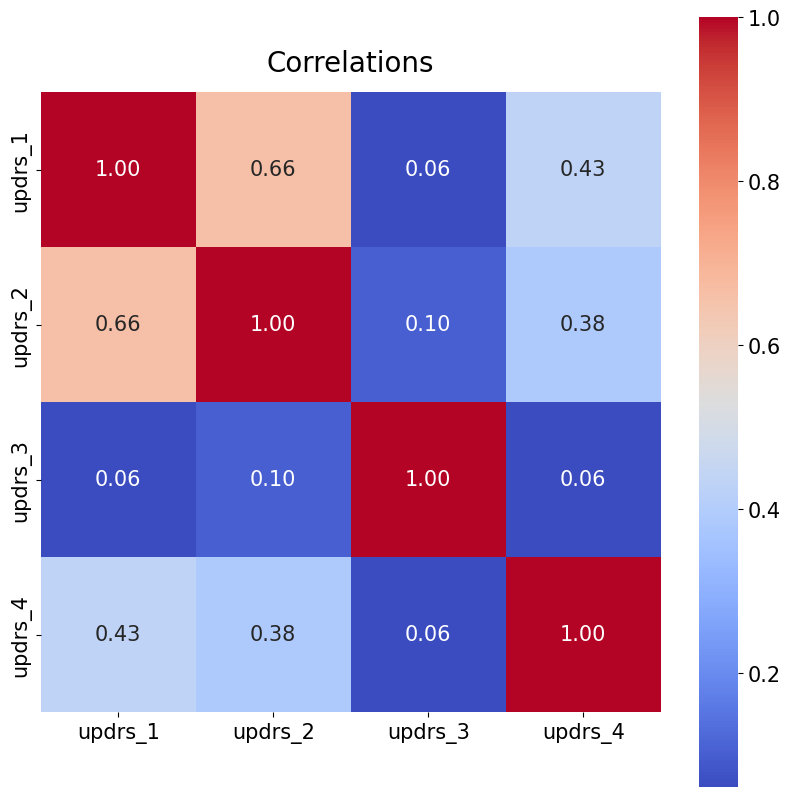

In [99]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
ax = sns.heatmap(
    clinical_data[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].corr(),
    annot=True,
    square=True,
    cmap='coolwarm',
    annot_kws={'size': 15},
    fmt='.2f'
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title('Correlations', size=20, pad=15)
plt.show()


From the heatmap, it can be seen that all of the updrs columns are positively correlated with each other since all of the symptoms get worse progressively.

# Analysing NaN in all the datasets

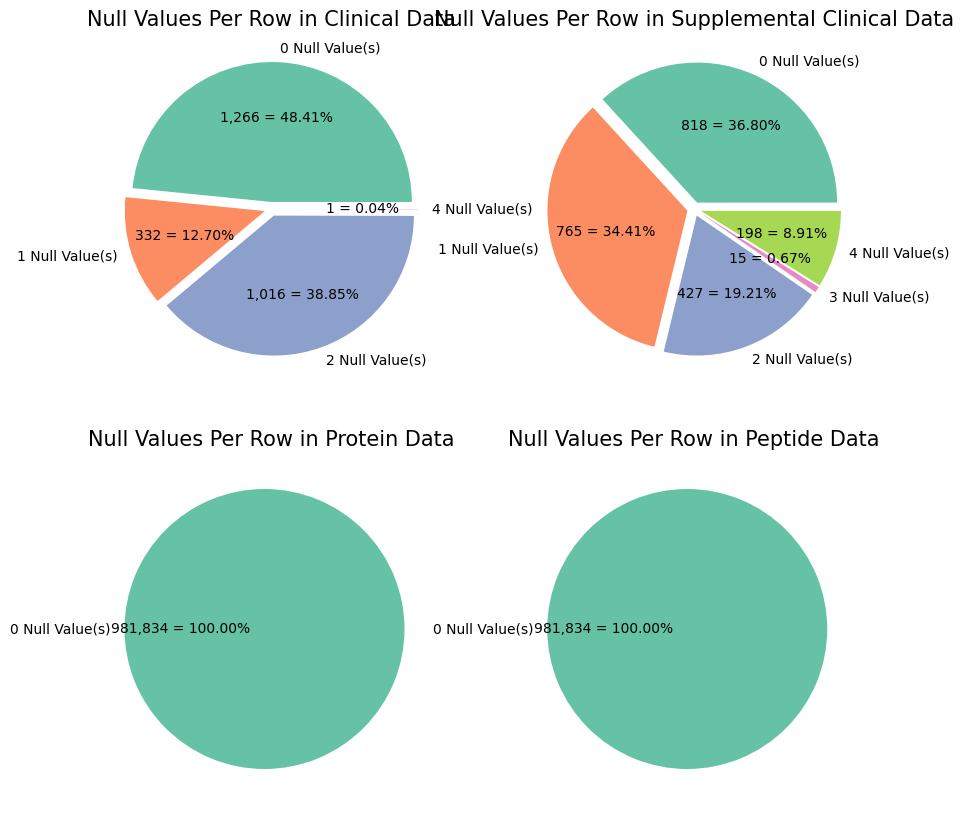

In [100]:
clinical_data["null_count"] = clinical_data.isnull().sum(axis=1)
counts_clinical_data = clinical_data.groupby(
    "null_count")["visit_id"].count().to_dict()
null_clinical_data = {
    "{} Null Value(s)".format(k): v for k,
    v in counts_clinical_data.items()}

peptides_data["null_count"] = peptides_data.isnull().sum(axis=1)
counts_peptides_data = peptides_data.groupby(
    "null_count")["visit_id"].count().to_dict()
null_peptides_data = {
    "{} Null Value(s)".format(k): v for k,
    v in counts_peptides_data.items()}

peptides_data["null_count"] = peptides_data.isnull().sum(axis=1)
counts_peptides_data = peptides_data.groupby(
    "null_count")["visit_id"].count().to_dict()
null_peptides_data = {
    "{} Null Value(s)".format(k): v for k,
    v in counts_peptides_data.items()}

sup_clinical_data["null_count"] = sup_clinical_data.isnull().sum(axis=1)
counts_sup_clinical_data = sup_clinical_data.groupby(
    "null_count")["visit_id"].count().to_dict()
null_sup_clinical_data = {
    "{} Null Value(s)".format(k): v for k,
    v in counts_sup_clinical_data.items()}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

axs = axs.flatten()

_ = axs[0].pie(
    x=list(null_clinical_data.values()),
    autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(null_clinical_data.values())/100, x),
    explode=[0.05] * len(null_clinical_data.keys()),
    labels=null_clinical_data.keys(),
    colors=sns.color_palette("Set2")[0:len(null_clinical_data.keys())],
)
_ = axs[0].set_title("Null Values Per Row in Clinical Data", fontsize=15)

_ = axs[3].pie(
    x=list(null_peptides_data.values()),
    autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(null_peptides_data.values())/100, x),
    explode=[0.05] * len(null_peptides_data.keys()),
    labels=null_peptides_data.keys(),
    colors=sns.color_palette("Set2")[0:len(null_peptides_data.keys())],
)
_ = axs[3].set_title("Null Values Per Row in Peptide Data", fontsize=15)

_ = axs[2].pie(
    x=list(null_peptides_data.values()),
    autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(null_peptides_data.values())/100, x),
    explode=[0.05] * len(null_peptides_data.keys()),
    labels=null_peptides_data.keys(),
    colors=sns.color_palette("Set2")[0:len(null_peptides_data.keys())],
)
_ = axs[2].set_title("Null Values Per Row in Protein Data", fontsize=15)

_ = axs[1].pie(
    x=list(null_sup_clinical_data.values()),
    autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(null_sup_clinical_data.values())/100, x),
    explode=[0.05] * len(null_sup_clinical_data.keys()),
    labels=null_sup_clinical_data.keys(),
    colors=sns.color_palette("Set2")[0:len(null_sup_clinical_data.keys())],
)
_ = axs[1].set_title(
    "Null Values Per Row in Supplemental Clinical Data",
    fontsize=15)


We don't have any null values when it comes to CSF observations with the peptide and protein data. We do however see null values when it comes to the clinical and supplemental clinical data. This doesn't mean that peptide and protien data doesn't have NaN values at all. The proteins and peptides data are constructed in such a way that for every visit id, the protiens or peptides that are recorded alone is tabulated. When we use a pivot table of visit_id against all the protiens and peptides, we will NaN values which will be handled in the exploratory data analysis below. 

# Filing NaN values of Clinical data

In [101]:
clinical_data['updrs_1'] = clinical_data['updrs_1'].fillna(
    clinical_data['updrs_1'].median())
clinical_data['updrs_2'] = clinical_data['updrs_2'].fillna(
    clinical_data['updrs_2'].median())
clinical_data['updrs_3'] = clinical_data['updrs_3'].fillna(
    clinical_data['updrs_3'].median())
clinical_data['updrs_4'] = clinical_data['updrs_4'].fillna(
    clinical_data['updrs_4'].median())
clinical_data['upd23b_clinical_state_on_medication'] = clinical_data['upd23b_clinical_state_on_medication'].fillna(
    'Missing')


In [102]:
visualizationMethod = input("How do you want to visualize the graph? (Box/Hist)")

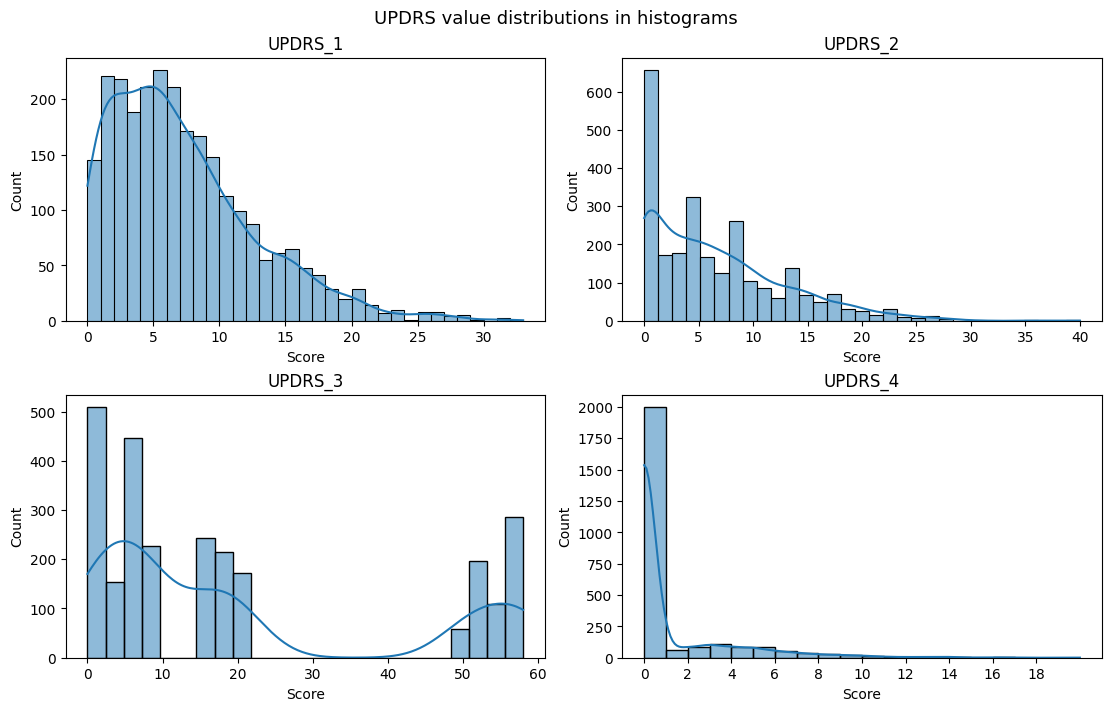

In [103]:

if visualizationMethod.lower() == 'hist':
    f, axes = plt.subplots(2, 2, layout="constrained",
                        figsize=(11, 7))

    f.suptitle('UPDRS value distributions in histograms', fontsize=13)

    splot = sns.histplot(
        ax=axes[0][0],
        x=clinical_data['updrs_1'],
        kde=True,
        alpha=0.5)
    splot.set_xlabel('Score')
    splot.set_ylabel('Count')
    splot.set_title('UPDRS_1')

    splot = sns.histplot(
        ax=axes[0][1],
        x=clinical_data['updrs_2'],
        kde=True,
        alpha=0.5,
        ec='black')
    splot.set_xlabel('Score')
    splot.set_ylabel('Count')
    splot.set_title('UPDRS_2')

    splot = sns.histplot(
        ax=axes[1][0],
        x=clinical_data['updrs_3'],
        kde=True,
        alpha=0.5,
        ec='black')
    splot.set_xlabel('Score')
    splot.set_ylabel('Count')
    splot.set_title('UPDRS_3')

    splot = sns.histplot(
        ax=axes[1][1],
        x=clinical_data['updrs_4'],
        kde=True,
        bins=range(
            0,
            20),
        alpha=0.5,
        ec='black')
    splot.set_xticks(range(0, 20, 2))
    splot.set_xlabel('Score')
    splot.set_ylabel('Count')
    splot.set_title('UPDRS_4')


    plt.show()


In [104]:
if visualizationMethod.lower() == 'box':
    f, axes = plt.subplots(2, 2, layout="constrained",
                        figsize=(11, 7))

    f.suptitle('UPDRS value distributions in Box plot', fontsize=13)

    splot = sns.boxplot(ax=axes[0][0], x=clinical_data['updrs_1'])
    splot.set_title('UPDRS_1')

    splot = sns.boxplot(ax=axes[0][1], x=clinical_data['updrs_2'])
    splot.set_title('UPDRS_2')

    splot = sns.boxplot(ax=axes[1][0], x=clinical_data['updrs_3'])
    splot.set_title('UPDRS_3')

    splot = sns.boxplot(ax=axes[1][1], x=clinical_data['updrs_4'])
    splot.set_title('UPDRS_4')


In [105]:
fig = px.histogram(clinical_data,
                   x='visit_month',
                   color='upd23b_clinical_state_on_medication',
                   title="<b>Count of visit_month. Please hover over to see specfic data. This is a kind of interaction",
                   width=1000, height=500)
fig.update_layout(title_font_size=20)
fig.show()


In [106]:
for updrs_part in ['1', '2', '3', '4']:
    fig = px.histogram(
        clinical_data,
        x=f'updrs_{updrs_part}',
        color='upd23b_clinical_state_on_medication',
        title=f'<b>Count of UPDRS Part {updrs_part} score (train_clinical_data.csv)',
        width=1000,
        height=500)
    fig.update_layout(title_font_size=20)
    fig.show()


In [107]:

parts = ['1', '2', '3', '4']
fig = make_subplots(
    rows=4,
    cols=3,
    horizontal_spacing=0.10,
    vertical_spacing=0.06,
    column_titles=[
        'Medication: "On"',
        'Medication: "Off"',
        'Medication: "Missing"'])

for i, medication in enumerate([['On'], ['Off'], ['Missing']]):
    train_clinical_df_ = clinical_data.query(
        'upd23b_clinical_state_on_medication in @medication')
    for j, part in enumerate(parts):
        fig.add_trace(go.Box(x=train_clinical_df_['visit_month'],
                             y=train_clinical_df_[f'updrs_{part}']),
                      row=j+1, col=i+1)

        fig.update_xaxes(title_text='Visit Month', row=j+1, col=i+1)
        fig.update_yaxes(title_text=f'UPDRS Part {part}', row=j+1, col=1)


fig.update_layout(
    width=850, height=2000,
    title_text='<b>UPDRS Score - Visit Month',
    showlegend=False)
fig.show()


# Plotting disease progression of Patient 23391 by filling NaN with median of the entire column

[Text(0.5, 1.0, 'Progression of updrs scores for partient 23391')]

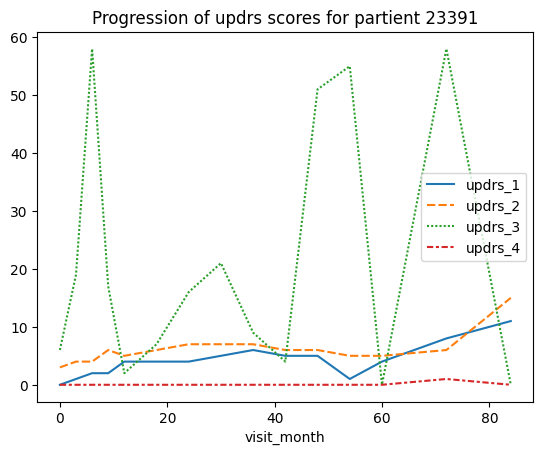

In [108]:
sns.lineplot(data=clinical_data[clinical_data['patient_id'] == 23391][['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4',
             'visit_month']].set_index('visit_month')).set(title='Progression of updrs scores for partient 23391')


As it can be seen from the above graph, for patient 23391, the updrs_1 and updrs_2 doesn't fluctutate much but eventually shows an increasing pattern whereas updre_3 is high volume of fluctuations. Lastly, updrs_4 remains almost constant throught. 

<AxesSubplot: xlabel='visit_month'>

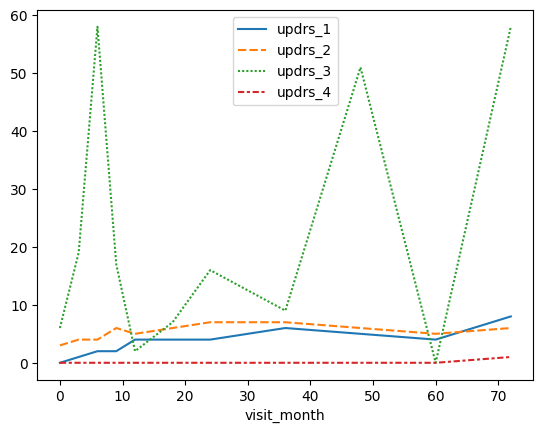

In [109]:
sns.lineplot(data=clinical_data[(clinical_data['patient_id'] == 23391) & (clinical_data['upd23b_clinical_state_on_medication'] != 'On')][[
             'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'visit_month']].set_index('visit_month'))


As it can be seen from the above graph, for patient 23391 when he isn't in medication, the updrs_1 and updrs_2 doesn't fluctutate much but eventually shows an increasing pattern whereas updre_3 is high volume of fluctuations. Lastly, updrs_4 remains almost constant throught. 

# Long term patients analysis

In [110]:
patient_ids = clinical_data[clinical_data['visit_month'] > 60]['patient_id']
long_term_patients = clinical_data[clinical_data['patient_id'].isin(
    patient_ids)]
display(long_term_patients)


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,null_count
13,942_0,942,0,3.0,2.0,6,0.0,Missing,2
14,942_3,942,3,7.0,2.0,19,0.0,Missing,2
15,942_6,942,6,8.0,2.0,58,0.0,Missing,2
16,942_12,942,12,5.0,2.0,2,0.0,Missing,1
17,942_18,942,18,6.0,5.0,7,0.0,Missing,1
...,...,...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,51,0.0,Off,0
2611,65043_54,65043,54,4.0,8.0,55,1.0,Off,0
2612,65043_60,65043,60,6.0,6.0,0,1.0,Off,0
2613,65043_72,65043,72,3.0,9.0,58,1.0,Off,0


In [111]:
long_term_patients.groupby('patient_id')[
    'upd23b_clinical_state_on_medication'].value_counts().sort_values(ascending=False)


patient_id  upd23b_clinical_state_on_medication
50907       Missing                                14
51708       Missing                                13
6054        Missing                                13
40200       On                                     13
49995       On                                     12
                                                   ..
40874       On                                      1
27872       Off                                     1
27971       Off                                     1
29313       On                                      1
65043       On                                      1
Name: upd23b_clinical_state_on_medication, Length: 282, dtype: int64

# Plotting disease progression of Patient 40200 (heavy medication)

In [112]:
long_term_patients[long_term_patients['patient_id'] == 40200]


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,null_count
1562,40200_0,40200,0,0.0,4.0,6,0.0,Missing,2
1563,40200_3,40200,3,0.0,4.0,19,0.0,Missing,2
1564,40200_6,40200,6,0.0,6.0,58,0.0,Missing,2
1565,40200_9,40200,9,0.0,5.0,17,0.0,On,0
1566,40200_12,40200,12,1.0,10.0,2,0.0,On,0
1567,40200_18,40200,18,0.0,9.0,7,0.0,On,0
1568,40200_24,40200,24,2.0,3.0,16,0.0,On,0
1569,40200_30,40200,30,3.0,9.0,21,0.0,On,0
1570,40200_36,40200,36,0.0,7.0,9,0.0,On,0
1571,40200_42,40200,42,4.0,15.0,4,0.0,On,0


<AxesSubplot: xlabel='visit_month'>

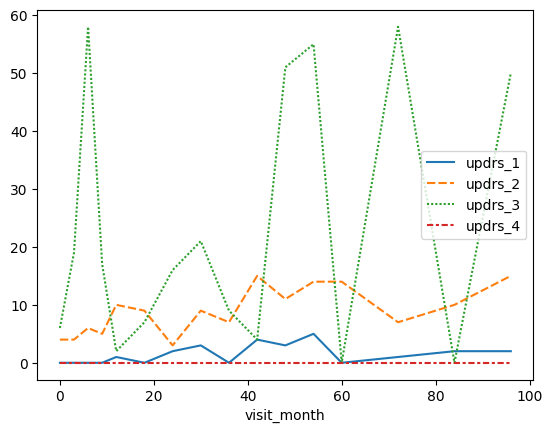

In [113]:
sns.lineplot(data=long_term_patients[long_term_patients['patient_id'] == 40200][[
             'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'visit_month']].set_index('visit_month'))


# Plotting disease progression of Patient 64674 (minimal medication)

In [114]:
long_term_patients[long_term_patients['patient_id'] == 64674]


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,null_count
2584,64674_0,64674,0,5.0,1.0,6,0.0,Missing,2
2585,64674_3,64674,3,5.0,2.0,19,0.0,Missing,2
2586,64674_6,64674,6,11.0,7.0,58,0.0,Missing,2
2587,64674_9,64674,9,10.0,6.0,17,0.0,Missing,2
2588,64674_12,64674,12,9.0,9.0,2,0.0,Missing,2
2589,64674_18,64674,18,3.0,6.0,7,0.0,Missing,2
2590,64674_24,64674,24,12.0,12.0,16,0.0,Missing,2
2591,64674_30,64674,30,12.0,18.0,21,0.0,Missing,2
2592,64674_36,64674,36,11.0,18.0,9,1.0,Missing,1
2593,64674_42,64674,42,5.0,18.0,4,2.0,Missing,1


[Text(0.5, 1.0, 'Progression of disease for patient 64674 while in medication')]

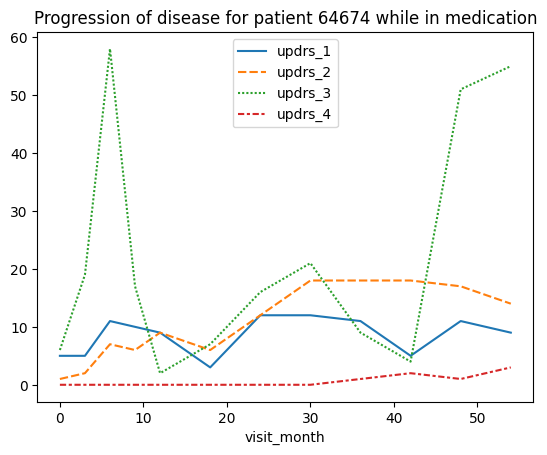

In [115]:
sns.lineplot(data=long_term_patients[(long_term_patients['patient_id'] == 64674) & (long_term_patients['upd23b_clinical_state_on_medication'] != 'Off')][[
             'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'visit_month']].set_index('visit_month')).set(title='Progression of disease for patient 64674 while in medication')


[Text(0.5, 1.0, 'Progression of disease for patient 64674 while not in medication')]

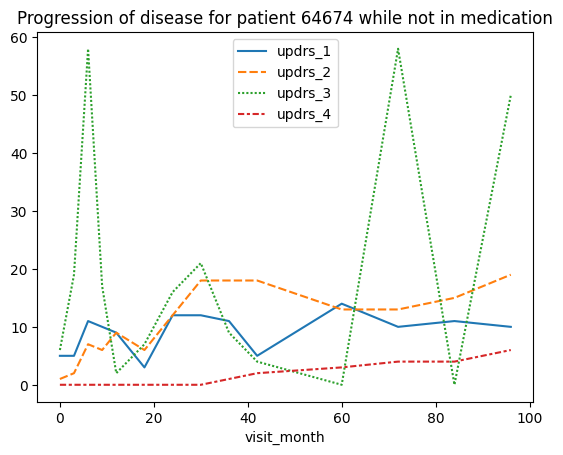

In [116]:
sns.lineplot(data=long_term_patients[(long_term_patients['patient_id'] == 64674) & (long_term_patients['upd23b_clinical_state_on_medication'] != 'On')][[
             'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'visit_month']].set_index('visit_month')).set(title='Progression of disease for patient 64674 while not in medication')


# Short term patients analysis

In [117]:
temp = pd.DataFrame(clinical_data.groupby('patient_id')[
                    'visit_month'].max().sort_values(ascending=True))
temp.reset_index(inplace=True)
patient_ids = temp[temp['visit_month'] < 30]['patient_id']
short_term_patients = clinical_data[clinical_data['patient_id'].isin(
    patient_ids)]
short_term_patients.head(5)


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,null_count
297,10053_0,10053,0,3.0,0.0,6,0.0,Missing,1
298,10053_6,10053,6,2.0,4.0,58,0.0,Missing,1
299,10053_12,10053,12,4.0,2.0,2,0.0,Missing,1
300,10053_18,10053,18,2.0,2.0,7,0.0,Missing,1
301,10053_24,10053,24,4.0,3.0,16,0.0,Missing,1


# Plotting disease progression of patient 52119

[Text(0.5, 1.0, 'Progression of disease in patient 52119')]

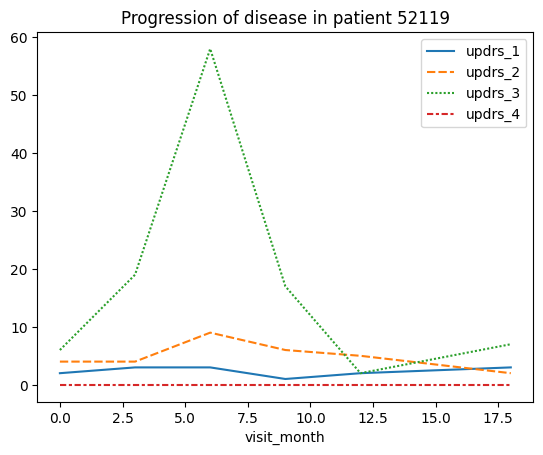

In [118]:
sns.lineplot(data=short_term_patients[short_term_patients['patient_id'] == 52119][[
             'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'visit_month']].set_index('visit_month')).set(title='Progression of disease in patient 52119')


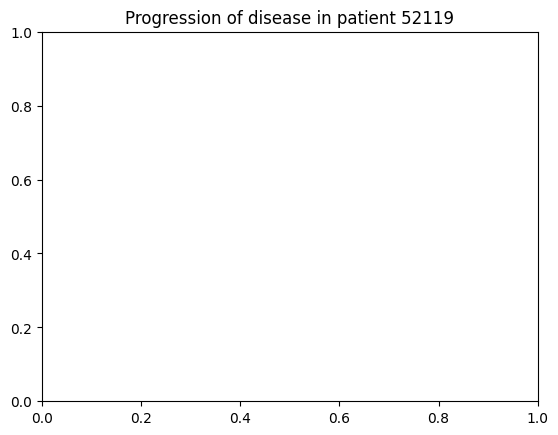

In [119]:
other_patient = input("Do you want to visualize the graph for some other patient? If yes, please provide the patient id.")

if other_patient:
    sns.lineplot(data=short_term_patients[short_term_patients['patient_id'] == int(other_patient)][[
             'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'visit_month']].set_index('visit_month')).set(title='Progression of disease in patient 52119')


# Proteins data anlysis

The second part of the dataset is proteins. Columns in proteins are:

visit_id: ID of the visit
visit_month: Month of the visit relative to the first visit by the patient
patient_id: ID of the patient
UniProt: UniProt ID code for the associated protein
NPX: Normalized protein expression
Protein data consist of protein expression frequencies aggregated from the peptide level data and UniProt ID codes. Number of patients in protein data match with clinical data. There are 227 unique proteins, 938.5 proteins per patient and 209.1 proteins per patient-visit on average.

UniProt ID code in protein data is a unique identifier assigned to a protein sequence entry in the UniProt database, which is a comprehensive resource for protein sequence and functional information. UniProt IDs consist of letters and numbers, and they typically begin with a prefix that identifies the type of entry.

There aren't any missing values in protein data.

In [120]:
proteins_data.head(5)


,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [121]:
proteins_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232741 entries, 0 to 232740
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   visit_id     232741 non-null  object 
 1   visit_month  232741 non-null  int64  
 2   patient_id   232741 non-null  int64  
 3   UniProt      232741 non-null  object 
 4   NPX          232741 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 8.9+ MB


In [122]:
proteins_data.describe()


,visit_month,patient_id,NPX
count,232741.000000,232741.000000,2.327410e+05
mean,26.099205,32593.881873,2.712077e+06
std,22.874719,18608.479506,2.224155e+07
min,0.000000,55.000000,8.460820e+01
25%,6.000000,16566.000000,2.946440e+04
50%,24.000000,29313.000000,1.135560e+05
75%,48.000000,49995.000000,5.638940e+05
max,108.000000,65043.000000,6.138510e+08


In [123]:
print(proteins_data.isna().sum())


visit_id       0
visit_month    0
patient_id     0
UniProt        0
NPX            0
dtype: int64


In [124]:
print("Found {:,d} unique patient_id values".format(
    proteins_data["patient_id"].nunique()))
print("Found {:,d} unique visit_month values".format(
    proteins_data["visit_month"].nunique()))
print("Found {:,d} unique UniProt values".format(
    proteins_data["UniProt"].nunique()))


Found 248 unique patient_id values
Found 15 unique visit_month values
Found 227 unique UniProt values


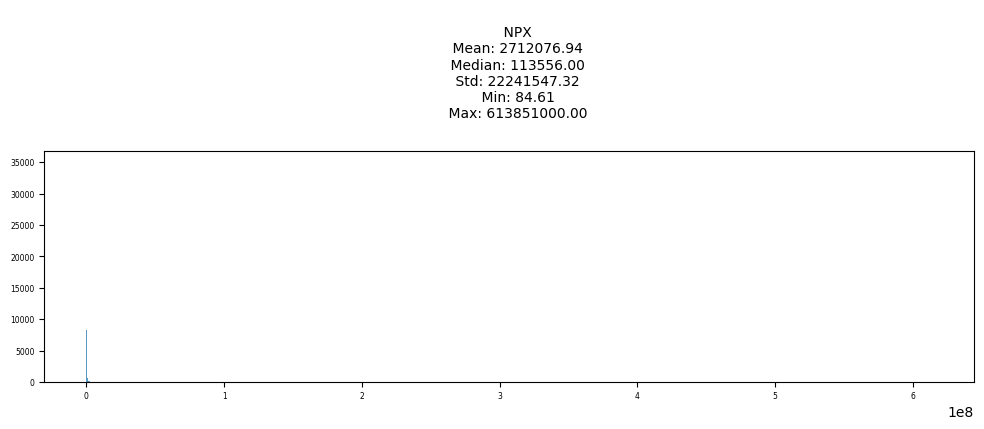

In [125]:
visualize_continuous_data_histogram(df=proteins_data, column='NPX')


As shown above, the NPX distribution is heavily skewed and thus we will use log scale to plot it.

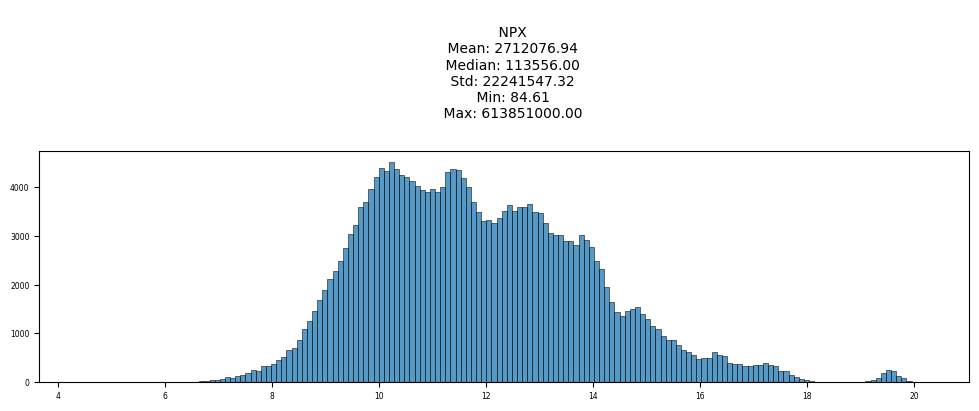

In [126]:
log_scale = input("You can't see anything in the current plot because the data is highly imbalanced. Do you want visulize in log scale? (yes/no)")
if log_scale == 'yes':
    visualize_continuous_data_histogram(
        df=proteins_data, column='NPX', log_scale=True)


In [127]:
unique_visits = len(clinical_data['visit_id'].unique())
print(f'Unique visits: {unique_visits}')


Unique visits: 2615


In [128]:
print(f'records: {len(proteins_data)}')

unique_visits = len(proteins_data['visit_id'].unique())
print(f'Unique visits: {unique_visits}')

unique_proteins = len(proteins_data['UniProt'].unique())
print(f'Unique proteins: {unique_proteins}')

unique_patients = len(proteins_data['patient_id'].unique())
print(f'Unique patients: {unique_patients}')

visit_min = proteins_data['visit_month'].min()
visit_max = proteins_data['visit_month'].max()
print(f'Visit month range: ({visit_min}, {visit_max})')


records: 232741
Unique visits: 1113
Unique proteins: 227
Unique patients: 248
Visit month range: (0, 108)


In [129]:
uniprot_count = proteins_data.groupby('visit_id')['UniProt'].count()
display(uniprot_count.value_counts().sort_index(ascending=False).head(5))
display(uniprot_count.describe())


224     5
223     6
222    12
221    23
220    36
Name: UniProt, dtype: int64

count    1113.000000
mean      209.111411
std        12.033458
min        37.000000
25%       206.000000
50%       212.000000
75%       216.000000
max       224.000000
Name: UniProt, dtype: float64

In [130]:
print("No of unique patients in each visit")
display(proteins_data.groupby('visit_month')[
        'patient_id'].nunique().to_frame().T)
print("No of records in each visit")
proteins_data['visit_month'].value_counts().sort_index().to_frame().T


No of unique patients in each visit


visit_month,0,3,6,12,18,24,30,36,48,54,60,72,84,96,108
patient_id,194,3,124,180,8,173,1,149,138,2,84,21,30,2,4


No of records in each visit


,0,3,6,12,18,24,30,36,48,54,60,72,84,96,108
visit_month,40587,641,25991,37467,1657,36225,216,31156,28838,418,17572,4407,6288,423,855


In [131]:
proteins_features = proteins_data.pivot(
    index='visit_id', columns='UniProt', values='NPX')
proteins_features


UniProt,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
visit_id,,,,,,,,,,,,,,,,,,,,,
10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,129048.0,...,NaN,9469.45,94237.6,NaN,23016.0,177983.0,65900.0,15382.0,NaN,19017.40
10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,108114.0,...,NaN,14408.40,NaN,NaN,28537.0,171733.0,65668.1,NaN,9295.65,25697.80
10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,163776.0,...,317477.0,38667.20,111107.0,NaN,37932.6,245188.0,59986.1,10813.3,NaN,29102.70
10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,56725.0,...,557904.0,44556.90,155619.0,14647.90,36927.7,229232.0,106564.0,26077.7,21441.80,7642.42
10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,85767.1,...,NaN,47836.70,177619.0,17061.10,25510.4,176722.0,59471.4,12639.2,15091.40,6168.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699_24,9983.00,400290.0,24240.10,NaN,16943.50,6303.17,77493.6,46435.3,254247.0,138910.0,...,NaN,25690.60,NaN,6859.82,19106.7,121161.0,113872.0,14413.9,28225.50,8062.07
942_12,6757.32,360858.0,18367.60,14760.7,18603.40,1722.77,86847.4,37741.3,212132.0,100519.0,...,45742.3,33518.60,94049.7,13415.70,21324.7,234094.0,82410.4,19183.7,17804.10,12277.00
942_24,NaN,352722.0,22834.90,23393.1,16693.50,1487.91,114772.0,36095.7,185836.0,99183.5,...,180475.0,29770.60,95949.9,11344.40,23637.6,256654.0,76931.9,19168.2,19215.90,14625.60


In [132]:
proteins_features_1 = proteins_data.pivot(
    index=[
        'patient_id',
        'visit_month'],
    columns='UniProt',
    values='NPX')
proteins_features_1


UniProt                  O00391     O00533   O00584   O14498    O14773  \
patient_id visit_month                                                   
55         0            11254.3   732430.0  39585.8  41526.9  31238.00   
           6            13163.6   630465.0  35220.8  41295.0  26219.90   
           12           15257.6   815083.0  41650.9  39763.3  30703.60   
           36           13530.8   753832.0  43048.9  43503.6  33577.60   
942        6            11218.7   399518.0  20581.0  31290.9   6173.58   
...                         ...        ...      ...      ...       ...   
64674      84               NaN   190487.0  24907.9  18543.1  10124.90   
65043      0            13472.4   927954.0  42661.5  43663.2  20071.30   
           12           14134.9   984651.0  28990.8  42440.9  25357.40   
           24           14659.5  1062020.0  46440.4  38293.0  21971.80   
           48           10589.6   902434.0  44890.8  38771.5  20188.30   

UniProt                  O14791    O15240    O15394    O43505    O60888  ...  \
patient_id visit_month                                                   ...   
55         0            4202.71  177775.0   62898.2  333376.0  166850.0  ...   
           6            4416.42  165638.0   62567.5  277833.0  170345.0  ...   
           12           4343.60  151073.0   66963.1  332401.0  151194.0  ...   
           36           5367.06  101056.0   67588.6  317490.0  122902.0  ...   
942        6            2564.37  160526.0   43423.1  165524.0   85272.7  ...   
...                         ...       ...       ...       ...       ...  ...   
64674      84           2308.71   62095.4   29248.7   87693.0   96801.4  ...   
65043      0            3278.88  266339.0  117884.0  382666.0  246063.0  ...   
           12           3267.66  270575.0  108246.0  321941.0  217877.0  ...   
           24           3990.34  221358.0  117204.0  348672.0  175961.0  ...   
           48           3137.07  203487.0   85782.0  160728.0  176787.0  ...   

UniProt                   Q9HDC9    Q9NQ79    Q9NYU2   Q9UBR2   Q9UBX5  \
patient_id visit_month                                                   
55         0            365475.0  35528.00   97005.6  23122.5  60912.6   
           6            405676.0  30332.60  109174.0  23499.8  51655.8   
           12           303953.0  43026.20  114921.0  21860.1  61598.2   
           36           303597.0  48188.40  109794.0  23930.6  70223.5   
942        6            253373.0  27431.80   93796.7  17450.9  21299.1   
...                          ...       ...       ...      ...      ...   
64674      84           260021.0   7139.93  104277.0  10500.0  21944.2   
65043      0            186414.0  25897.80       NaN  21480.7  57364.0   
           12           301343.0  22343.40  105626.0  20500.8  54011.2   
           24           300439.0  52143.60  139291.0  19449.2  66569.9   
           48           223136.0  21659.90  116470.0  14073.3  48796.4   

UniProt                   Q9UHG2   Q9UKV8   Q9UNU6   Q9Y646   Q9Y6R7  
patient_id visit_month                                                
55         0            408698.0      NaN  29758.8  23833.7  18953.5  
           6            369870.0      NaN  22935.2  17722.5  16642.7  
           12           318553.0  65762.6  29193.4  28536.1  19290.9  
           36           377550.0  74976.1  31732.6  22186.5  21717.1  
942        6            306621.0  82335.5  24018.7  18939.5  15251.2  
...                          ...      ...      ...      ...      ...  
64674      84           136725.0  62217.5      NaN  10287.7  13848.2  
65043      0            416142.0  37584.6      NaN  28346.5  35617.5  
           12           380072.0  40588.9      NaN  17035.7  37064.2  
           24           300948.0  36150.4      NaN  21286.3  39587.9  
           48           320821.0  39046.7      NaN  20198.8  39535.0  

[1113 rows x 227 columns]

### Variance
Find average variance across patients and across months. This tells the importance of filling nan with average of patient or avg of month. Eg, if average variance across patients is very less, that means the patient determine the protein npx levels and thus nans can be filled by each patient's average.

In [133]:
proteins_features_1.query('patient_id == 2660')


UniProt                  O00391    O00533   O00584   O14498    O14773  \
patient_id visit_month                                                  
2660       0                NaN  579829.0  28259.8  29883.2  19134.10   
           6                NaN  673129.0  32040.8  36289.5  22368.30   
           12           15516.2  779498.0  35938.3  49586.5  29522.50   
           24               NaN  743746.0  32525.6  32157.8   4674.86   
           48               NaN  771095.0  33814.9  47828.2  29928.50   

UniProt                  O14791    O15240   O15394    O43505    O60888  ...  \
patient_id visit_month                                                  ...   
2660       0            1884.61  134409.0  70664.8  213295.0  229999.0  ...   
           6            2066.33  166920.0  84632.2  237007.0  285073.0  ...   
           12           2420.14  267756.0  73046.1  349190.0  217461.0  ...   
           24           1663.35  188875.0  85157.2  231779.0  295610.0  ...   
           48           2087.76  215996.0  81565.7  267789.0  259278.0  ...   

UniProt                   Q9HDC9   Q9NQ79    Q9NYU2   Q9UBR2   Q9UBX5  \
patient_id visit_month                                                  
2660       0            224909.0  32224.2  127529.0  14148.6  26387.0   
           6            262758.0  36865.9  130364.0  17123.7  37659.9   
           12           444934.0  62133.5  167043.0      NaN  36361.1   
           24           330574.0  35736.2  125303.0  16774.0  31730.0   
           48           208432.0  40533.1  132293.0  13707.8  39310.7   

UniProt                   Q9UHG2   Q9UKV8   Q9UNU6   Q9Y646   Q9Y6R7  
patient_id visit_month                                                
2660       0            294153.0  55047.2  17880.5  25630.0  17990.9  
           6            350459.0  54896.2  20326.5  25334.7  24419.4  
           12           453013.0  81213.7  29266.6  25080.2  24100.1  
           24           311041.0  57694.0  17076.3  28899.9  15679.4  
           48           427263.0  74070.9  21556.8  25000.7  24798.6  

[5 rows x 227 columns]

In [134]:
proteins_features_1.groupby('patient_id').std().mean()


UniProt
O00391     1800.924413
O00533    94987.309047
O00584     5752.822347
O14498     4618.302561
O14773     3447.624632
              ...     
Q9UHG2    52341.025249
Q9UKV8    11687.821092
Q9UNU6     3912.007990
Q9Y646     3301.722211
Q9Y6R7     4750.504922
Length: 227, dtype: float64

In [135]:
proteins_features_1.groupby('visit_month').std().mean()


UniProt
O00391      2461.451909
O00533    274890.739707
O00584      9617.879798
O14498      9099.775126
O14773      8241.988260
              ...      
Q9UHG2    112378.494719
Q9UKV8     26955.932069
Q9UNU6      6196.737253
Q9Y646      5950.244038
Q9Y6R7      9010.426818
Length: 227, dtype: float64

In [136]:
patient_var = proteins_features_1.groupby('patient_id').std().mean()
month_var = proteins_features_1.groupby('visit_month').std().mean()
print((month_var/patient_var).mean())


1.8177160614065204


Since the above value is greater than 1, it means patient-id tells more about the npx value

# Filling NaN

In [137]:
print("Total nan values: ", proteins_features.isna().sum().sum())
proteins_features.isna().sum().sort_values(ascending=False).to_frame().T


Total nan values:  19910


UniProt,Q99829,Q99832,Q562R1,P01780,Q6UX71,O75326,P06310,P19827,P36980,P02655,...,P01876,P02751,P02749,P23142,P41222,P01011,P02649,P02647,Q12805,P01042
0,624,507,497,459,452,419,418,415,409,404,...,0,0,0,0,0,0,0,0,0,0


In [138]:
proteins_features_1.groupby('patient_id').mean()


UniProt,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
patient_id,,,,,,,,,,,,,,,,,,,,,
55,13301.575,732952.500000,39876.600000,41522.200000,30434.775000,4582.4475,148885.500000,65004.350000,315275.000000,152822.750000,...,344675.250000,39268.800000,107723.650000,23103.250,61097.525000,368667.750000,70369.350000,28405.000000,23069.700000,19151.050000
942,9867.940,341229.500000,20957.500000,23951.300000,15977.670000,1973.1200,111096.825000,36851.675000,182781.250000,92462.575000,...,169394.325000,30001.200000,101373.075000,15345.200,20746.575000,257417.500000,84645.925000,20872.875000,17512.325000,14643.075000
1517,10969.500,552938.000000,31469.900000,24136.833333,22759.025000,3018.9175,119928.025000,57152.975000,203169.250000,155771.425000,...,266538.750000,37667.350000,NaN,16583.075,33555.300000,228064.500000,61940.733333,22460.175000,19620.150000,21091.825000
1923,21361.800,793890.666667,30228.433333,47823.450000,14090.666667,NaN,257554.333333,70094.633333,340470.666667,243465.333333,...,107803.333333,58747.433333,139185.000000,16594.700,67328.366667,510925.000000,133290.766667,29150.500000,25363.233333,24934.500000
2660,15516.200,709459.400000,32515.880000,39149.040000,21125.652000,2024.4380,194791.200000,79013.200000,259812.000000,257484.200000,...,294321.400000,41498.580000,136506.400000,15438.525,34289.740000,367185.800000,64584.400000,21221.340000,25989.100000,21397.680000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63875,11980.700,636355.400000,31819.700000,27861.620000,22741.200000,2692.6900,125521.800000,62693.600000,213756.400000,166549.000000,...,201022.000000,44946.260000,125133.400000,16041.820,35570.280000,267431.400000,67820.640000,22623.660000,20569.100000,20656.180000
63889,NaN,413628.166667,26970.516667,NaN,14425.683333,NaN,113897.500000,24825.146667,137974.000000,77529.116667,...,42948.500000,15727.364000,123276.750000,15042.800,42873.766667,217128.333333,64767.440000,18046.666667,17473.150000,NaN
64669,10806.500,430561.800000,27622.380000,25122.560000,14849.120000,2918.0800,83104.260000,41662.000000,180097.200000,139964.400000,...,261092.200000,23707.800000,108763.740000,15342.240,34192.580000,172804.800000,64995.300000,20445.400000,18041.100000,22972.920000


### Data cleaning
1. For the month 30, only one patient is present (50611)
2. For the month 54, only two patients are present (207, 211)

Should we remove the above data?

In [139]:
proteins_data.query('visit_month == 54')['patient_id'].value_counts()


4161    211
8344    207
Name: patient_id, dtype: int64

In [140]:
proteins_data.pivot_table(
    index='visit_id',
    values='UniProt',
    aggfunc=np.count_nonzero).describe()


,UniProt
count,1113.000000
mean,209.111411
std,12.033458
min,37.000000
25%,206.000000
50%,212.000000
75%,216.000000
max,224.000000


<AxesSubplot: ylabel='Frequency'>

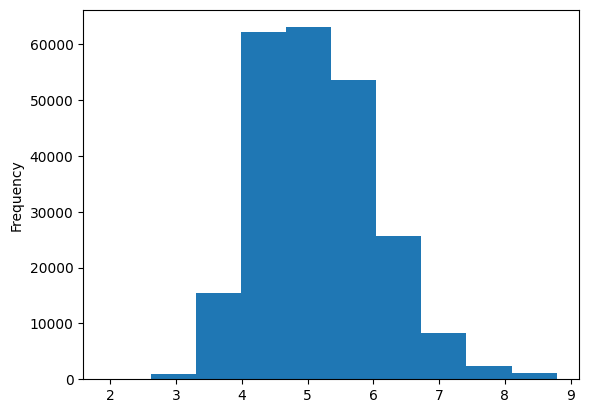

In [141]:
np.log10(proteins_data['NPX']).plot.hist()


In [142]:
protein_npx_mean = proteins_data.pivot_table(
    index='UniProt',
    values='NPX',
    aggfunc=np.median)
protein_npx_mean


,NPX
UniProt,
O00391,11546.40
O00533,483442.50
O00584,26529.70
O14498,26624.00
O14773,17399.60
...,...
Q9UHG2,214051.00
Q9UKV8,67571.70
Q9UNU6,18977.00


In [143]:
np.log10(protein_npx_mean).describe()


,NPX
count,227.000000
mean,5.114229
std,0.882528
min,3.312357
25%,4.424503
50%,4.991102
75%,5.701241
max,8.485493


<AxesSubplot: ylabel='Frequency'>

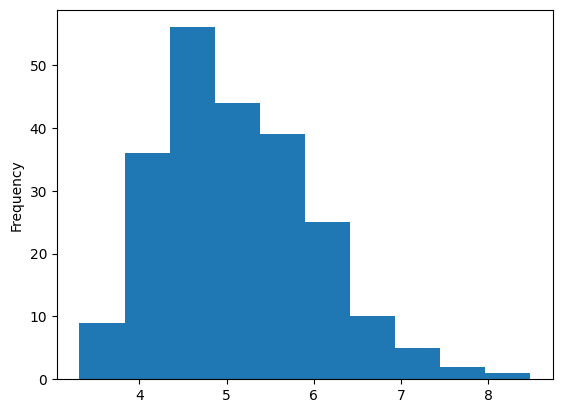

In [144]:
np.log10(protein_npx_mean['NPX']).plot.hist()


In [145]:
def visualize_value_counts(value_counts, title):
    """
    Visualize values and their counts in given dictionary

    Parameters
    ----------
    value_counts: dict
        Dictionary of values and their counts

    title: str
        Title of the plot
    """

    fig, ax = plt.subplots(figsize=(12, 10), dpi=100)
    ax.barh(range(len(value_counts)), value_counts.values(), align='center')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks(range(len(value_counts)))
    ax.set_yticklabels([f'{x} ({value_count:,})' for x,
                       value_count in value_counts.items()])
    ax.tick_params(axis='x', labelsize=10, pad=10)
    ax.tick_params(axis='y', labelsize=10, pad=10)
    ax.set_title(title, size=10, pad=15)
    plt.gca().invert_yaxis()
    plt.show()


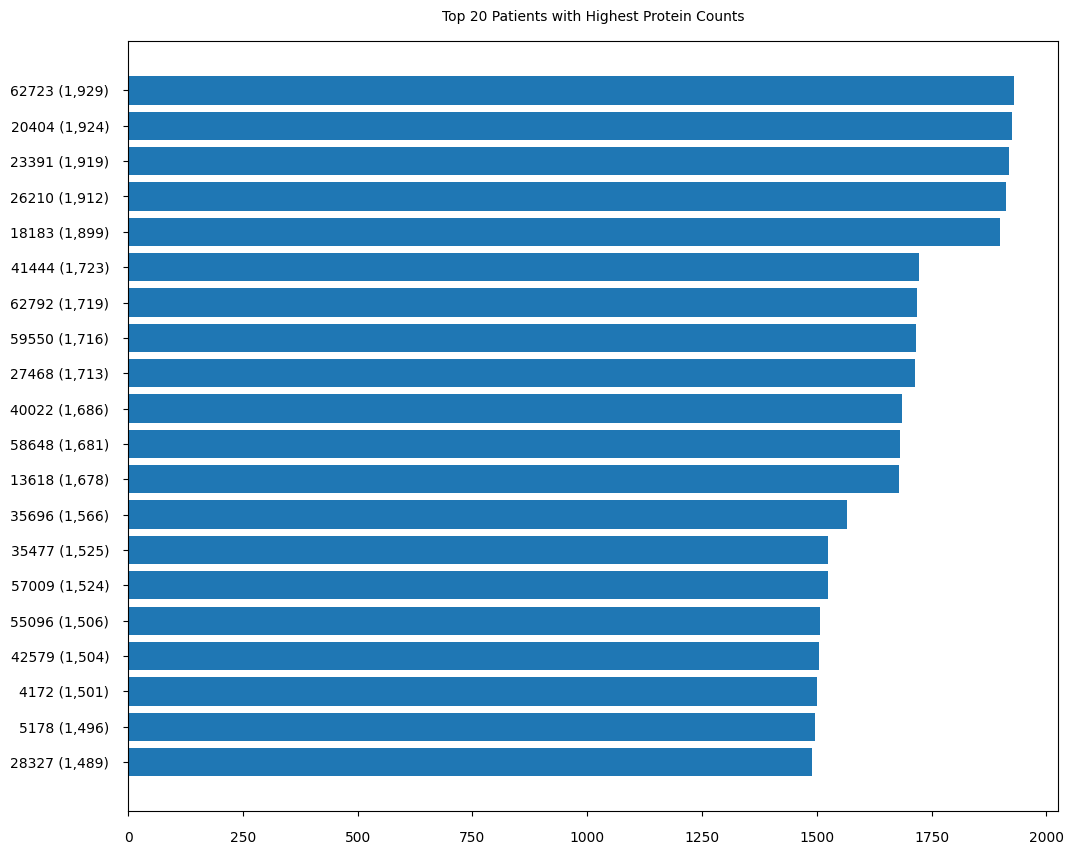

In [146]:
patient_id_value_counts = proteins_data['patient_id'].value_counts().head(
    20).to_dict()
visualize_value_counts(patient_id_value_counts,
                       'Top 20 Patients with Highest Protein Counts')


A patient's protein count can be between 1900 and 199 which is mostly dependent to number of visits. Patients with highest protein counts are visualized below.

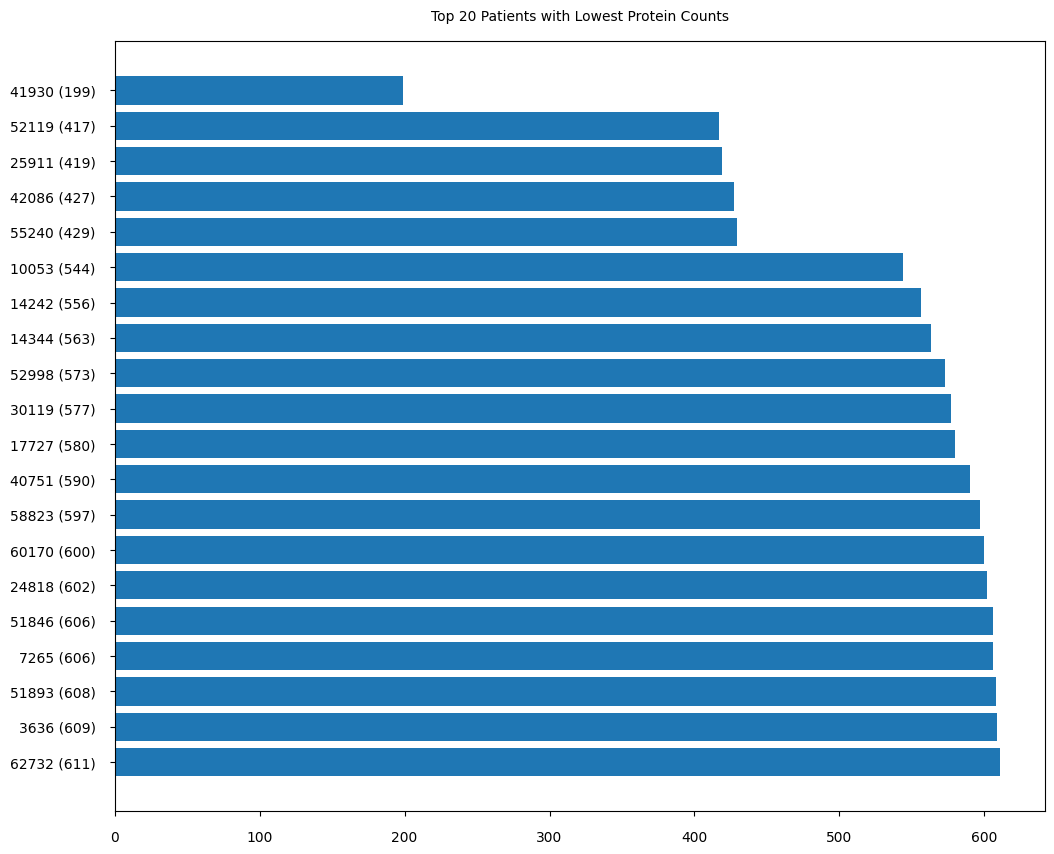

In [147]:
patient_id_value_counts = proteins_data['patient_id'].value_counts(
).sort_values(ascending=True).head(20).to_dict()
visualize_value_counts(patient_id_value_counts,
                       'Top 20 Patients with Lowest Protein Counts')


The above graph represents the patients with lowest protein counts are visualized above.

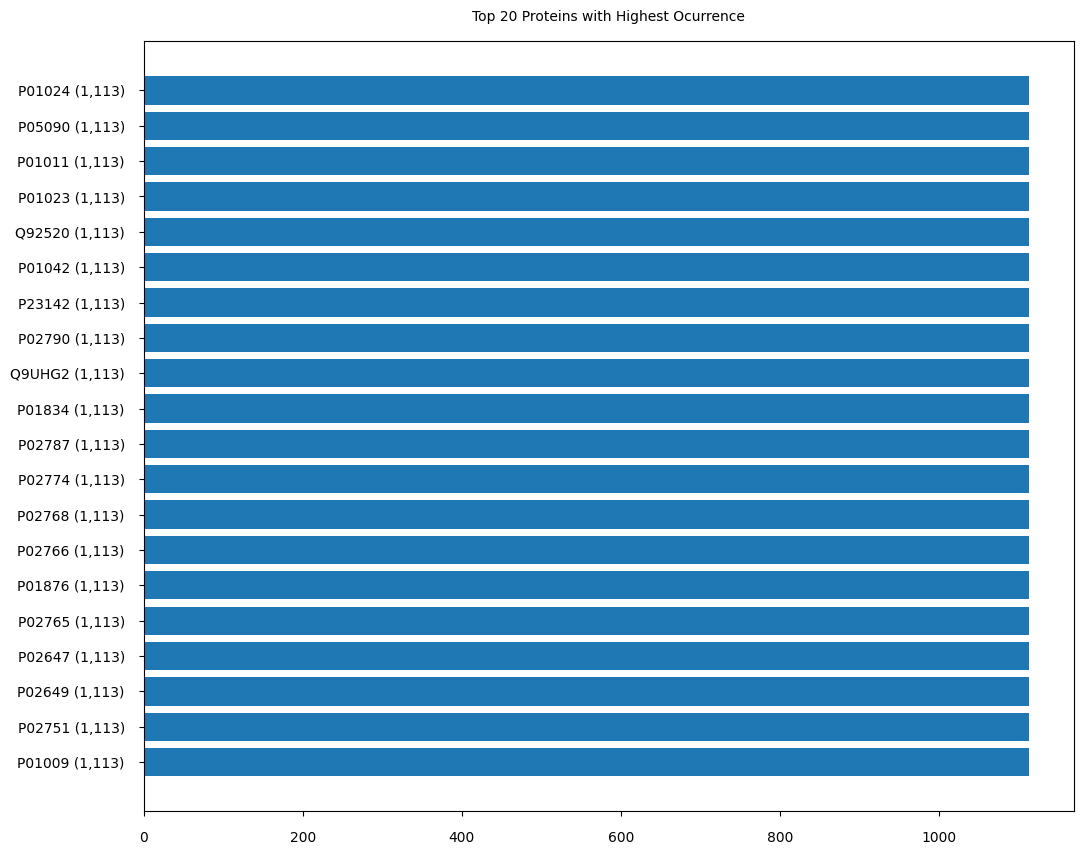

In [148]:
uniprot_value_counts = proteins_data['UniProt'].value_counts().head(
    20).to_dict()
visualize_value_counts(
    uniprot_value_counts,
    'Top 20 Proteins with Highest Ocurrence')


A protein's value count can be between 1113 and 489. Proteins are equally represented to some degree. Proteins with highest value counts are visualized above.

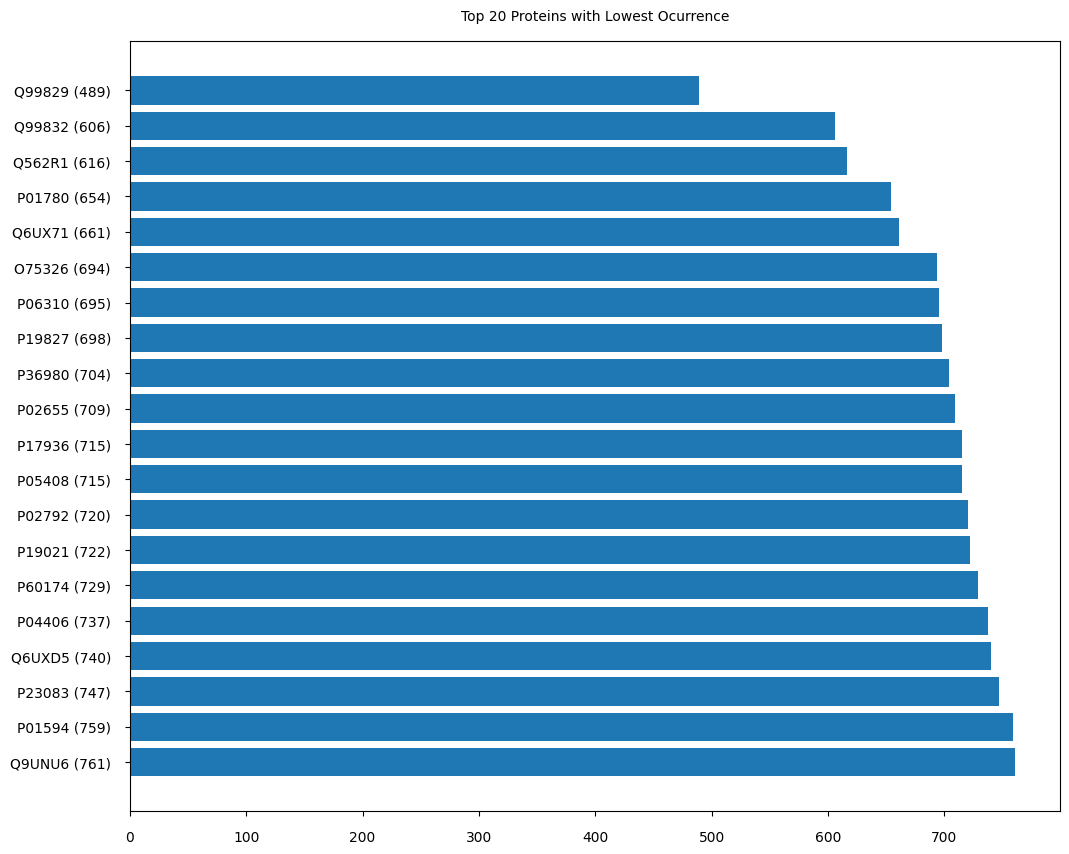

In [149]:
uniprot_value_counts = proteins_data['UniProt'].value_counts(
).sort_values(ascending=True).head(20).to_dict()
visualize_value_counts(
    uniprot_value_counts,
    'Top 20 Proteins with Lowest Ocurrence')


Proteins with lowest value counts are visualized above.

In [150]:
# Calculate the coefficient of variation (CV) for NPX per patient_ids and
# UniProt
train_proteins_df_agg = proteins_data[['patient_id', 'UniProt', 'NPX']]
train_proteins_df_agg = train_proteins_df_agg.groupby(
    ['patient_id', 'UniProt'])['NPX'] .aggregate(['mean', 'std'])
train_proteins_df_agg['CV_NPX[%]'] = train_proteins_df_agg['std'] / \
    train_proteins_df_agg['mean'] * 100
# Mean CV value for UniProt
NPX_cv_mean = train_proteins_df_agg.groupby(
    'UniProt')['CV_NPX[%]'].mean().reset_index()
NPX_cv_mean = NPX_cv_mean.sort_values(
    by='CV_NPX[%]',
    ascending=False).reset_index(
        drop=True)
protein_cv_top5 = NPX_cv_mean[:5]['UniProt']

train_proteins_df_agg_top5 = train_proteins_df_agg.query(
    'UniProt in @protein_cv_top5').reset_index()
# Sort by protein_cv_top5 rank
train_proteins_df_agg_top5['order'] = 0
for i, protein in enumerate(protein_cv_top5):
    index = train_proteins_df_agg_top5.query(f'UniProt=="{protein}"').index
    train_proteins_df_agg_top5.loc[index, 'order'] = i
train_proteins_df_agg_top5.sort_values(by='order', inplace=True)

fig = px.violin(train_proteins_df_agg_top5,
                y='UniProt',
                x='CV_NPX[%]',
                color='UniProt',
                box=True,
                title='<b>Coeffcient of Variation for NPX (Top 5)',
                width=900, height=500)
fig.update_layout(showlegend=False, xaxis=dict(
    title='Coeffcient of Variation [%] of NPX per patient_id'))
fig.show()


In [151]:
# Merge protiens and clinical data on visit_id
protein_medication_df = pd.merge(
    proteins_data,
    clinical_data[['visit_id', 'upd23b_clinical_state_on_medication']],
    on='visit_id',
)
protein_medication_df


,visit_id,visit_month,patient_id,UniProt,NPX,upd23b_clinical_state_on_medication
0,55_0,0,55,O00391,11254.3,Missing
1,55_0,0,55,O00533,732430.0,Missing
2,55_0,0,55,O00584,39585.8,Missing
3,55_0,0,55,O14498,41526.9,Missing
4,55_0,0,55,O14773,31238.0,Missing
...,...,...,...,...,...,...
223263,58648_108,108,58648,Q9UBX5,27387.8,Missing
223264,58648_108,108,58648,Q9UHG2,369437.0,Missing
223265,58648_108,108,58648,Q9UKV8,105830.0,Missing
223266,58648_108,108,58648,Q9Y646,21257.6,Missing


In [152]:
# Filling NaN values of 'upd23b_clinical_state_on_medication' with 'Missing'
protein_medication_df['upd23b_clinical_state_on_medication'] = \
    protein_medication_df['upd23b_clinical_state_on_medication'].fillna('Missing')


In [153]:
protein_cv_top5 = NPX_cv_mean[:5]['UniProt'].reset_index(drop=True)
tmp_df = protein_medication_df[['visit_month',
                                'patient_id',
                                'UniProt',
                                'NPX',
                                'upd23b_clinical_state_on_medication']]
top5_protein_df = tmp_df.query('UniProt in @protein_cv_top5')
fig = make_subplots(
    rows=5,
    cols=3,
    horizontal_spacing=0.10,
    vertical_spacing=0.06,
    column_titles=[
        '<b>Medication: On',
        '<b>Medication: Off'
        '<b>Medication: Missing'],
    shared_yaxes=True)
for i, medication in enumerate([['On'], ['Off'], ['Missing']]):
    top5_protein_df_ = top5_protein_df.query(
        'upd23b_clinical_state_on_medication in @medication')
    for j, protein in enumerate(protein_cv_top5):
        protein_df = top5_protein_df_.query(f'UniProt=="{protein}"')
        fig.add_trace(go.Box(x=protein_df['visit_month'], y=protein_df['NPX']),
                      row=j+1, col=i+1)

        fig.update_xaxes(title_text='Visit Month', row=j+1, col=i+1)
        fig.update_yaxes(title_text=f'{protein} NPX', row=j+1, col=1)

fig.update_layout(width=1000, height=2000,
                  title_text='<b>NPX - Visit Month (Highest top5 CV)',
                  showlegend=False)
fig.show()


In [154]:
# Get protein candidate from proteins with higher variability of NPX
num_protein_candidates = 5
protein_candidates = NPX_cv_mean.loc[:num_protein_candidates-1, 'UniProt']

# Create dataframe with columns:['visit_id', 'protein_candidata1',
# 'protein_candidata2', ...]
train_proteins_candidate_df = proteins_data.query(
    f'UniProt in @protein_candidates')
visit_ids = train_proteins_candidate_df['visit_id'].unique()
protein_dict_list = []
for visit_id in visit_ids:
    proteins_df = train_proteins_candidate_df.query(f'visit_id=="{visit_id}"')
    UniProts = proteins_df['UniProt'].values
    NPXs = proteins_df['NPX'].values
    protein_dict = dict(
        zip(protein_candidates, [np.nan]*num_protein_candidates))
    for UniProt, NPX in zip(UniProts, NPXs):
        protein_dict[UniProt] = NPX
    protein_dict['visit_id'] = visit_id
    protein_dict_list.append(protein_dict)

protein_candidate_df = pd.DataFrame(protein_dict_list)

# Concatinate train_clinical_df to protein_candidate_df
clinical_protein_df = pd.merge(clinical_data,
                               protein_candidate_df,
                               on='visit_id')

# Heatmap
clinical_protein_df_ = clinical_protein_df.drop(
    ['visit_id', 'patient_id', 'visit_month', 'upd23b_clinical_state_on_medication'], axis=1)
corr = clinical_protein_df_.corr()
px.imshow(
    corr,
    width=600,
    height=600,
    title='<b>Correlation: UPDRS scores and Protein NPX')


# Peptides

In [155]:
peptides_data.head()


,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,null_count
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3,0
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0,0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0,0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9,0
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7,0


In [156]:
peptides_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981834 entries, 0 to 981833
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   visit_id          981834 non-null  object 
 1   visit_month       981834 non-null  int64  
 2   patient_id        981834 non-null  int64  
 3   UniProt           981834 non-null  object 
 4   Peptide           981834 non-null  object 
 5   PeptideAbundance  981834 non-null  float64
 6   null_count        981834 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 52.4+ MB


In [157]:
peptides_data.describe()


,visit_month,patient_id,PeptideAbundance,null_count
count,981834.000000,981834.000000,9.818340e+05,981834.0
mean,26.105061,32603.465361,6.428902e+05,0.0
std,22.913897,18605.934422,3.377989e+06,0.0
min,0.000000,55.000000,1.099850e+01,0.0
25%,6.000000,16566.000000,2.817425e+04,0.0
50%,24.000000,29313.000000,7.430830e+04,0.0
75%,48.000000,49995.000000,2.213388e+05,0.0
max,108.000000,65043.000000,1.787520e+08,0.0


In [158]:
print(peptides_data.isna().sum())


visit_id            0
visit_month         0
patient_id          0
UniProt             0
Peptide             0
PeptideAbundance    0
null_count          0
dtype: int64


In [159]:
print("Found {:,d} unique patient_id values".format(
    peptides_data["patient_id"].nunique()))
print("Found {:,d} unique UniProt values".format(
    peptides_data["UniProt"].nunique()))
print("Found {:,d} unique Peptide values".format(
    peptides_data["Peptide"].nunique()))


Found 248 unique patient_id values
Found 227 unique UniProt values
Found 968 unique Peptide values


In [160]:
# Calculate the coefficient of variation (CV) for PeptideAbundance per
# patient_ids and Peptides
train_peptides_df_agg = peptides_data[[
    'patient_id', 'Peptide', 'PeptideAbundance']]
train_peptides_df_agg = train_peptides_df_agg.groupby(
    ['patient_id', 'Peptide'])['PeptideAbundance'] .aggregate(['mean', 'std'])
train_peptides_df_agg['CV_PeptideAbundance[%]'] = \
    train_peptides_df_agg['std'] / train_peptides_df_agg['mean'] * 100

# Mean CV value of Peptides
abundance_cv_mean = train_peptides_df_agg.groupby(
    'Peptide')['CV_PeptideAbundance[%]'].mean().reset_index()
abundance_cv_mean = abundance_cv_mean.sort_values(
    by='CV_PeptideAbundance[%]', ascending=False).reset_index(drop=True)
peptide_cv_top5 = abundance_cv_mean[:5]['Peptide']

train_peptides_df_agg_top5 = train_peptides_df_agg.query(
    'Peptide in @peptide_cv_top5').reset_index()
# Sort by peptide_cv_top5 rank
train_peptides_df_agg_top5['order'] = 0
for i, peptide in enumerate(peptide_cv_top5):
    index = train_peptides_df_agg_top5.query(f'Peptide=="{peptide}"').index
    train_peptides_df_agg_top5.loc[index, 'order'] = i
train_peptides_df_agg_top5.sort_values(by='order', inplace=True)

fig = px.violin(
    train_peptides_df_agg_top5,
    y='Peptide',
    x='CV_PeptideAbundance[%]',
    color='Peptide',
    box=True,
    title='<b>Coeffcient of Variation (Top 5) of PeptideAbundance per patient_id',
    width=1000,
    height=800)

fig.update_layout(
    width=1000,
    height=500,
    showlegend=False,
    xaxis=dict(
        title='Coeffcient of variation [%] for PeptideAbundance per patient_id'),
    yaxis=dict(
        title='<b>Peptide'))
fig.show()


From the violin plot,  the cooefficients of variation of peptide pbundance are calculated for each patient_id and peptide type.

Merging the peptides and clinical data on visit_id

In [161]:
peptide_medication_df = pd.merge(
    peptides_data,
    clinical_data[['visit_id', 'upd23b_clinical_state_on_medication']],
    on='visit_id',
)


In [162]:
peptide_medication_df['upd23b_clinical_state_on_medication'] = \
    peptide_medication_df['upd23b_clinical_state_on_medication'].fillna('Missing')


In [163]:
peptide_cv_top5 = abundance_cv_mean[:5]['Peptide'].reset_index(drop=True)
tmp_df = peptide_medication_df[['visit_month',
                                'patient_id',
                                'Peptide',
                                'PeptideAbundance',
                                'upd23b_clinical_state_on_medication']]
top5_peptide_df = tmp_df.query('Peptide in @peptide_cv_top5')

num_patients = 50
fig = make_subplots(
    rows=5,
    cols=3,
    horizontal_spacing=0.10,
    vertical_spacing=0.06,
    column_titles=[
        '<b>Medication: On',
        '<b>Medication: Off',
        '<b>Medication: Missing'],
    shared_yaxes=True)

for i, medication in enumerate([['On'], ['Off'], ['Missing']]):
    top5_peptide_df_ = top5_peptide_df.query(
        'upd23b_clinical_state_on_medication in @medication')
    for j, peptide in enumerate(peptide_cv_top5):
        peptide_df = top5_peptide_df_.query(f'Peptide=="{peptide}"')
        fig.add_trace(go.Box(x=peptide_df['visit_month'],
                             y=peptide_df['PeptideAbundance']),
                      row=j+1, col=i+1)

        fig.update_xaxes(title_text='Visit Month', row=j+1, col=i+1)
        fig.update_yaxes(title_text=f'{peptide} Abundance', row=j+1, col=1)


fig.update_layout(
    width=1000,
    height=2000,
    title_text='<b>Peptide Abundance - Visit Month (Highest top5 CV)',
    showlegend=False)
fig.show()


In [164]:
# Get peptide candidate from peptides with higher variability of NPX
num_peptide_candidates = 5
peptide_candidates = abundance_cv_mean.loc[:
                                           num_peptide_candidates-1, 'Peptide']

# Create dataframe with columns:['visit_id', 'peptide_candidata1',
# 'peptide_candidata2', ...]
train_peptides_candidate_df = peptides_data.query(
    f'Peptide in @peptide_candidates')
visit_ids = train_peptides_candidate_df['visit_id'].unique()
peptide_dict_list = []
for visit_id in visit_ids:
    peptides_df = train_peptides_candidate_df.query(f'visit_id=="{visit_id}"')
    peptides = peptides_df['Peptide'].values
    PeptideAbundances = peptides_df['PeptideAbundance'].values
    peptide_dict = dict(
        zip(peptide_candidates, [np.nan]*num_peptide_candidates))
    for peptide, PeptideAbundance in zip(peptides, PeptideAbundances):
        peptide_dict[peptide] = PeptideAbundance
    peptide_dict['visit_id'] = visit_id
    peptide_dict_list.append(peptide_dict)

peptide_candidate_df = pd.DataFrame(peptide_dict_list)

# Concatinate train_clinical_df to peptide_candidate_df
clinical_peptide_df = pd.merge(clinical_data,
                               peptide_candidate_df,
                               on='visit_id')

# Heatmap
clinical_peptide_df_ = clinical_peptide_df.drop(
    ['visit_id', 'patient_id', 'visit_month', 'upd23b_clinical_state_on_medication'], axis=1)
corr = clinical_peptide_df_.corr()
px.imshow(
    corr,
    width=750,
    height=750,
    title='<b>Correlation: UPDRS scores and Peptides Abundance')


# Supplemental Clinical data

In [165]:
sup_clinical_data.head()


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,null_count
0,BF-1001_M0,17182,0,NaN,NaN,6,NaN,NaN,4
1,BF-1002_M0,60343,0,9.0,11.0,6,9.0,NaN,1
2,BF-1002_M0_5,60343,5,NaN,NaN,54,NaN,NaN,4
3,BF-1003_M0,573,0,8.0,11.0,6,4.0,NaN,1
4,BF-1003_M0_5,573,5,NaN,NaN,54,NaN,NaN,4


In [166]:
sup_clinical_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2223 entries, 0 to 2222
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   visit_id                             2223 non-null   object 
 1   patient_id                           2223 non-null   int64  
 2   visit_month                          2223 non-null   int64  
 3   updrs_1                              2010 non-null   float64
 4   updrs_2                              2009 non-null   float64
 5   updrs_3                              2223 non-null   int64  
 6   updrs_4                              1295 non-null   float64
 7   upd23b_clinical_state_on_medication  1122 non-null   object 
 8   null_count                           2223 non-null   int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 156.4+ KB


In [167]:
sup_clinical_data.describe()


,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,null_count
count,2223.000000,2223.000000,2010.000000,2009.000000,2223.000000,1295.000000,2223.000000
mean,32478.016194,12.910481,5.692537,6.517670,16.730994,0.840154,1.104813
std,18637.562796,13.060532,4.373661,4.970111,18.522241,1.860247,1.174009
min,35.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,16703.000000,0.000000,2.000000,2.000000,6.000000,0.000000,0.000000
50%,32915.000000,6.000000,5.000000,5.000000,7.000000,0.000000,1.000000
75%,47243.000000,24.000000,8.000000,10.000000,21.000000,0.000000,2.000000
max,65530.000000,36.000000,27.000000,34.000000,58.000000,12.000000,4.000000


In [168]:
print(sup_clinical_data.isna().sum())


visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                 213
updrs_2                                 214
updrs_3                                   0
updrs_4                                 928
upd23b_clinical_state_on_medication    1101
null_count                                0
dtype: int64


In [169]:
print("Found {:,d} unique patient_id values".format(
    sup_clinical_data["patient_id"].nunique()))
print("Found {:,d} unique visit_month values".format(
    sup_clinical_data["visit_month"].nunique()))


Found 771 unique patient_id values
Found 8 unique visit_month values


In [170]:
supplemental_clinical_df_copy = sup_clinical_data.copy()
supplemental_clinical_df_copy['upd23b_clinical_state_on_medication'] = \
    supplemental_clinical_df_copy['upd23b_clinical_state_on_medication'].fillna('Null')
all_clinical_df = pd.concat(
    [clinical_data_copy, supplemental_clinical_df_copy])
all_clinical_df['train_or_supplemental'] = 'train_data'
all_clinical_df['train_or_supplemental'][len(
    clinical_data):] = 'supplemental_data'

print(f'# train_clicnical_data: {len(clinical_data)}')
print(f'# supplemental_clicnical_data: {len(sup_clinical_data)}')

features = [
    'visit_month',
    'upd23b_clinical_state_on_medication',
    'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4',
]
for x in features:
    fig = px.histogram(all_clinical_df,
                       x=x,
                       color='train_or_supplemental',
                       title=f"<b>Count of {x}",
                       color_discrete_sequence=px.colors.qualitative.Vivid,
                       width=800, height=500)
    fig.update_layout(template="plotly_dark")
    fig.update_layout(title_font_size=20)
    fig.show()


# train_clicnical_data: 2615
# supplemental_clicnical_data: 2223


/var/folders/v2/jm_dv17j13sf8q7661clstym0000gn/T/ipykernel_18860/2493014671.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

